<a href="https://colab.research.google.com/github/qkrtnwjd4212/Time_Series_Data_Project/blob/main/Sliding_window_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta
!pip install pygad
!pip install backtesting

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 슬라이딩 윈도우 백테스트

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pygad
from backtesting import Backtest, Strategy
from datetime import timedelta
import matplotlib.pyplot as plt

# ✅ Smoothed price
def smooth_price(df, p=5, t=5):
    df = df.copy()

    # 두번의 지수이동평균을 순차적으로 적용하여 종가 데이터 스무딩
    df['close'] = df['close'].ewm(span=p).mean().ewm(span=t).mean()
    return df

# ✅ GDC 기반 전략 (매도 시 1% 수수료)
class GDCStrategy(Strategy):
    def init(self):
        self.signal = self.data.signal
        self.last_signal = None

    def next(self):
        if self.I == len(self.data) - 1:
              if self.position:
                  self.position.close()
              return

        current_signal = self.signal[-1]
        price = self.data.Close[-1]

        if self.position:
            if current_signal == -1 and self.position.is_short:
                self.position.close()
                self.buy()

            elif current_signal == 1 and self.position.is_long:
                self.position.close(size=self.position.size, reduce_only=False)
                self.sell()
        else:
            if current_signal == -1:
                self.buy()
            elif current_signal == 1:
                self.sell()

# ✅ SMA, EMA, MACD, RSI, Stochastic, ROC만 사용
def compute_indicators(df, params):
    df = df.copy()
    df = smooth_price(df)

    # SMA
    df['SMA'] = df['close'].rolling(int(params[0])).mean() - df['close'].rolling(int(params[1])).mean()

    # EMA
    df['EMA'] = df['close'].ewm(span=int(params[2]), adjust=False).mean() - df['close'].ewm(span=int(params[3]), adjust=False).mean()

    # MACD
    macd_fast = df['close'].ewm(span=int(params[4]), adjust=False).mean()
    macd_slow = df['close'].ewm(span=int(params[5]), adjust=False).mean()
    df['MACD'] = macd_fast - macd_slow
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # signal line

    # RSI
    delta = df['close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(int(params[6])).mean()
    ma_down = down.rolling(int(params[6])).mean()
    rs = ma_up / (ma_down + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic: %K, %D
    low_min = df['low'].rolling(int(params[7])).min()
    high_max = df['high'].rolling(int(params[7])).max()
    df['Stoch_K'] = (df['close'] - low_min) / (high_max - low_min + 1e-10) * 100
    df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()

    # ROC
    df['ROC'] = df['close'].pct_change(periods=int(params[8])) * 100

    # 수정 1
    df = df.dropna().copy()
    return df
    # return df.dropna()


# ✅ 신호 생성 함수
def generate_signal(df):
    signals = []
    for i in range(len(df)):
        row = df.iloc[i]
        score = 0

        # SMA: 단기 > 장기 (매수) → -1
        score += -1 if row['SMA'] > 0 else 1 if row['SMA'] < 0 else 0

        # EMA: 단기 > 장기 (매수) → -1
        score += -1 if row['EMA'] > 0 else 1 if row['EMA'] < 0 else 0

        # MACD: MACD선 > Signal선 (매수) → -1
        score += -1 if row['MACD'] > row['MACD_Signal'] else 1 if row['MACD'] < row['MACD_Signal'] else 0

        # RSI: 30 이하 과매도 (매수) → -1 / 70 이상 과매수 (매도) → +1
        score += -1 if row['RSI'] < 30 else 1 if row['RSI'] > 70 else 0

        # Stochastic: %K > %D (매수) → -1
        score += -1 if row['Stoch_K'] > row['Stoch_D'] else 1 if row['Stoch_K'] < row['Stoch_D'] else 0

        # ROC: > 0 (상승 추세, 매수) → -1
        score += -1 if row['ROC'] > 0 else 1 if row['ROC'] < 0 else 0

        # signals.append(1 if score >= 3 else -1 if score <= -3 else 0)
        # signals.append(1 if score >= 2 else -1 if score <= -2 else 0) # 시그널 기준 완화 1
        signals.append(1 if score >= 1 else -1 if score <= -1 else 0) # 시그널 기준 완화 2

    return np.array(signals)

def safe_commission(trade, order):
    try:
        return 0.01 * trade.value if hasattr(trade, 'is_short') and (trade.is_short or trade.side == 'sell') else 0
    except Exception:
        return 0
# def safe_commission(trade, order):
#     # 매도 거래이고, 포지션을 새로 여는 거래가 아닐 경우 (즉, 청산 목적이면)
#     if trade.side == 'sell' and not trade.is_entry:
#         return 0.01 * trade.value
#     return 0

# ✅ 커스텀 수수료 적용 (매도 시에만 1% 적용)
def backtest(df, signal):
    df_bt = df.copy()
    df_bt['signal'] = signal
    df_bt = df_bt[['open', 'high', 'low', 'close', 'volume', 'signal']].dropna()
    df_bt.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    df_bt.index.name = 'Date'
    bt = Backtest(
    df_bt,
    GDCStrategy,
    cash=100_000,
    commission=safe_commission,
    exclusive_orders=True
    )

    stats = bt.run()
    return stats['Return [%]'] / 100, stats['Max. Drawdown [%]'] / 100, stats['Sharpe Ratio']

# ✅ 데이터 로드
df_all = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stock/tictocstock.csv", parse_dates=['Date'])
df_all.columns = df_all.columns.str.strip().str.lower()
df_all = df_all[['date', 'ticker', 'open', 'high', 'low', 'close', 'volume']]
df_all.sort_values(['ticker', 'date'], inplace=True)

# ✅ TJX 데이터 불러오기
df = df_all[df_all['ticker'] == 'TJX'].set_index('date').copy().ffill()

# ✅ GA 피트니스 함수
def fitness_func(ga, solution, idx):
    try:
        params = [max(2, int(round(p))) for p in solution]
        if not (params[0] < params[1] and params[2] < params[3] and params[4] < params[5]):
            return -np.inf
        df_ind = compute_indicators(df, params)
        signal = generate_signal(df_ind)
        profit, mdd, sharpe = backtest(df_ind, signal)
        return 0.8 * profit + 0.2 * (1 / mdd)
    except:
        return -np.inf

# ✅ 유전자 범위
gene_space = [
    {'low': 5, 'high': 50},    # SMA short
    {'low': 10, 'high': 60},   # SMA long
    {'low': 5, 'high': 50},    # EMA short
    {'low': 10, 'high': 60},   # EMA long
    {'low': 5, 'high': 25},    # MACD fast
    {'low': 26, 'high': 60},   # MACD slow
    {'low': 5, 'high': 30},    # RSI
    {'low': 5, 'high': 40},    # Stoch
    {'low': 5, 'high': 30},    # ROC
]

# ✅ 최적 파라미터 보기 좋게 출력
def explain_best_params(params):
    names = [
        "SMA Short Window",  # params[0]
        "SMA Long Window",   # params[1]
        "EMA Short Window",  # params[2]
        "EMA Long Window",   # params[3]
        "MACD Fast",         # params[4]
        "MACD Slow",         # params[5]
        "RSI Period",        # params[6]
        "Stochastic Period", # params[7]
        "ROC Period",        # params[8]
    ]
    print("✅ 최적 파라미터 해석")
    for name, val in zip(names, params):
        print(f" - {name:20}: {val}")

# ✅ 슬라이딩 윈도우 백테스트 (GA 최적화 포함)
def run_quarterly_backtests(df, gene_space, ga_config, train_months, test_months):
    results = []
    test_months = 6

    current_start = pd.to_datetime(df.index.min())
    end_date = pd.to_datetime(df.index.max())

    while True:
        train_start = current_start
        train_end = train_start + pd.DateOffset(months=train_months)
        test_start = train_end
        test_end = test_start + pd.DateOffset(months=test_months)

        if test_end > end_date: break

        train_df = df.loc[train_start:train_end]
        test_df = df.loc[test_start:test_end]

        print(f"\n--- 훈련: {train_start.date()} ~ {train_end.date()} | 테스트: {test_start.date()} ~ {test_end.date()} ---")

        # 1. 현재 훈련 기간(train_df)을 사용하는 피트니스 함수를 내부에서 정의
        def fitness_func(ga, solution, idx):
            try:
                params = [max(2, int(round(p))) for p in solution]
                if not (params[0] < params[1] and params[2] < params[3] and params[4] < params[5]):
                    return -np.inf

                df_ind = compute_indicators(train_df, params)
                signal = generate_signal(df_ind)
                profit, mdd, sharpe = backtest(df_ind, signal)
                return 0.8 * profit + 0.2 * (1 / (mdd + 1e-10))
            except:
                return -np.inf

        # 2. GA 실행하여 현재 기간의 최적 파라미터 탐색
        ga_instance = pygad.GA(fitness_func=fitness_func, gene_space=gene_space, num_genes=len(gene_space), **ga_config)
        ga_instance.run()

        best_params = [int(round(p)) for p in ga_instance.best_solution()[0]]
        print(f"✅ 최적 파라미터: {best_params}")

        # 3. 찾은 파라미터로 테스트 기간(test_df)에 대한 백테스트 실행
        df_ind_test = compute_indicators(test_df, best_params)
        signal_test = generate_signal(df_ind_test)
        profit, mdd, sharpe = backtest(df_ind_test, signal_test)

        results.append({
            'start': test_start.date(),
            'end': test_end.date(),
            'profit': round(profit * 100, 2),
            'mdd': round(mdd * 100, 2),
            'sharpe': round(sharpe, 3),
            'best_params': best_params
        })

        # 4. 다음 기간으로 이동
        current_start += pd.DateOffset(months=test_months)

    return pd.DataFrame(results)

# ✅ GA 설정을 딕셔너리로 분리
ga_config = {
    'num_generations': 50,
    'num_parents_mating': 20,
    'sol_per_pop': 20,
    'gene_type': float,
    'mutation_type': "random",
    'mutation_percent_genes': 10
}

# ✅ 유전자 범위 (기존과 동일)
gene_space = [
    {'low': 5, 'high': 50},   # SMA short
    {'low': 10, 'high': 60},  # SMA long
    {'low': 5, 'high': 50},   # EMA short
    {'low': 10, 'high': 60},  # EMA long
    {'low': 5, 'high': 25},   # MACD fast
    {'low': 26, 'high': 60},  # MACD slow
    {'low': 5, 'high': 30},   # RSI
    {'low': 5, 'high': 40},   # Stoch
    {'low': 5, 'high': 30},   # ROC
]


# ✅ 전진 분석 실행 (12개월 훈련, 3개월 테스트)
# 이 함수 하나를 호출하면 내부에서 GA 최적화와 백테스트를 모두 반복 수행
result_df = run_quarterly_backtests(df, gene_space, ga_config, train_months=6, test_months=6)

print("\n--- 전진 분석 최종 결과 ---")
print(result_df)



 # 위 코드 결과 시각화


--- 각 테스트 기간별 매매 신호 시각화 ---


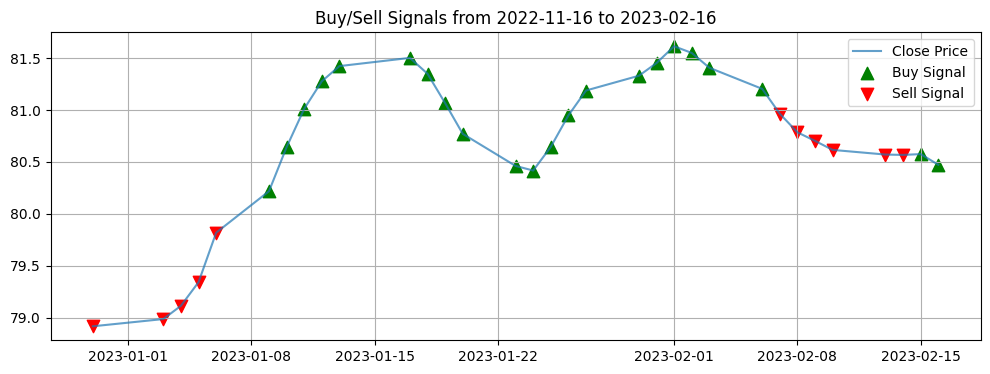

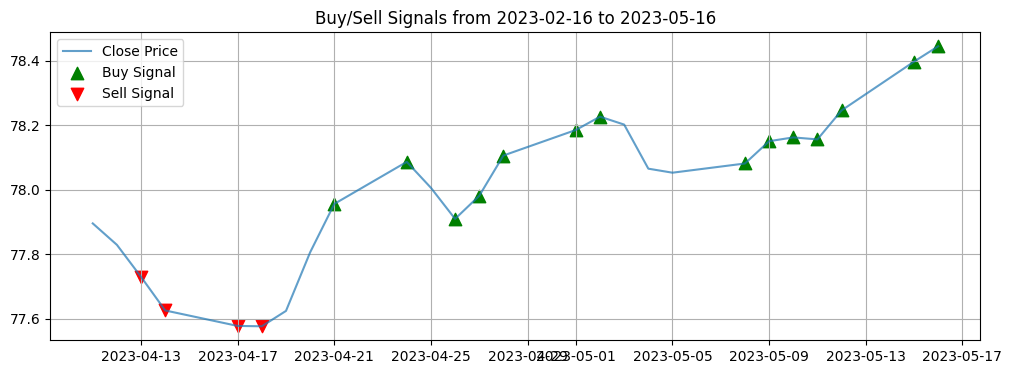

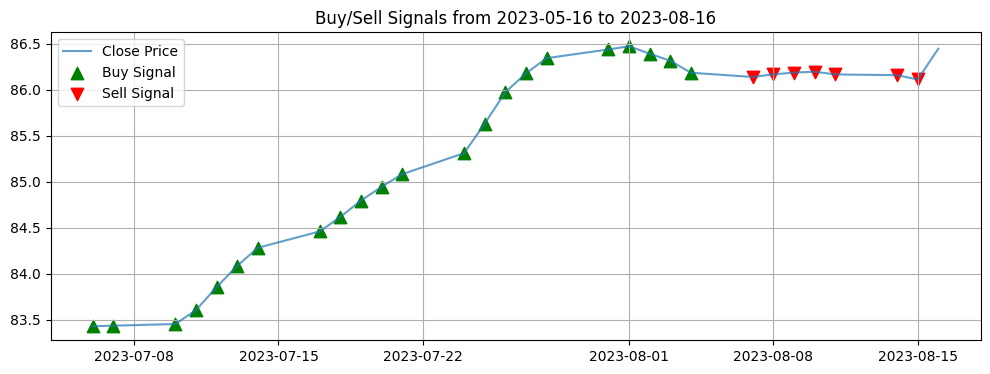

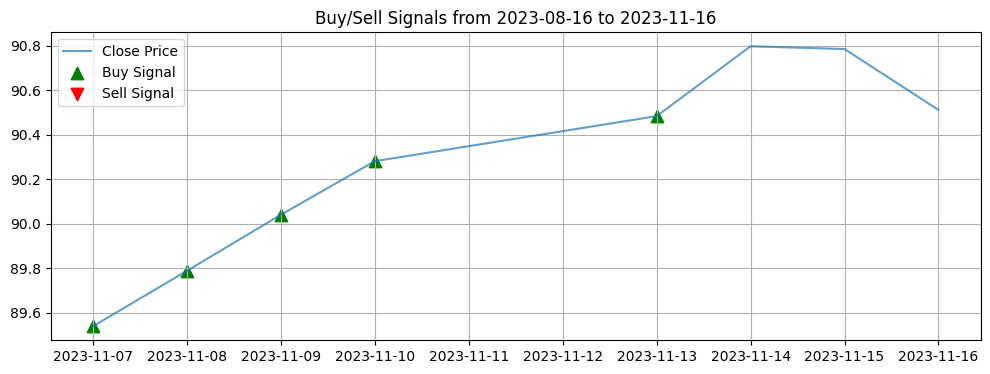

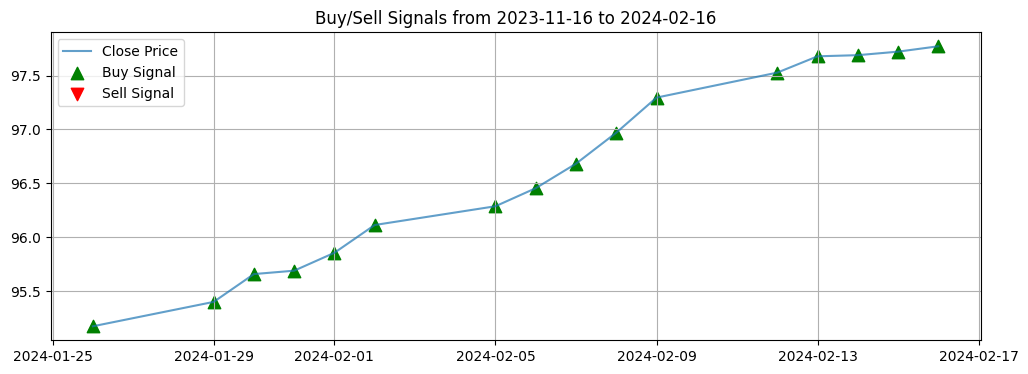

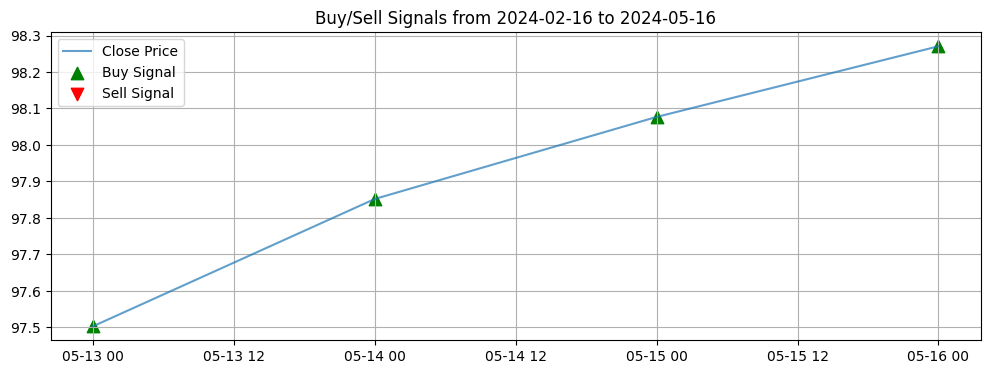

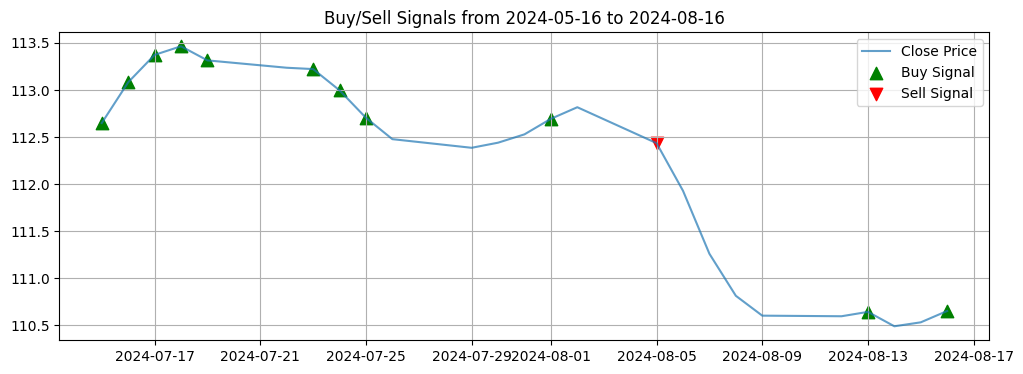

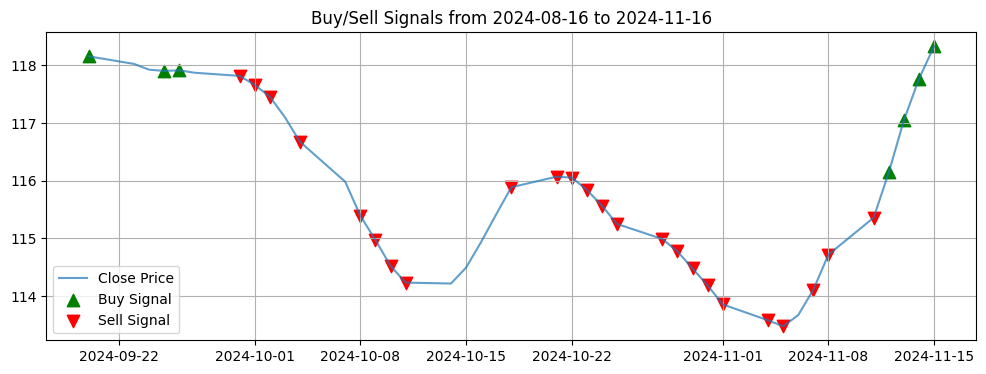

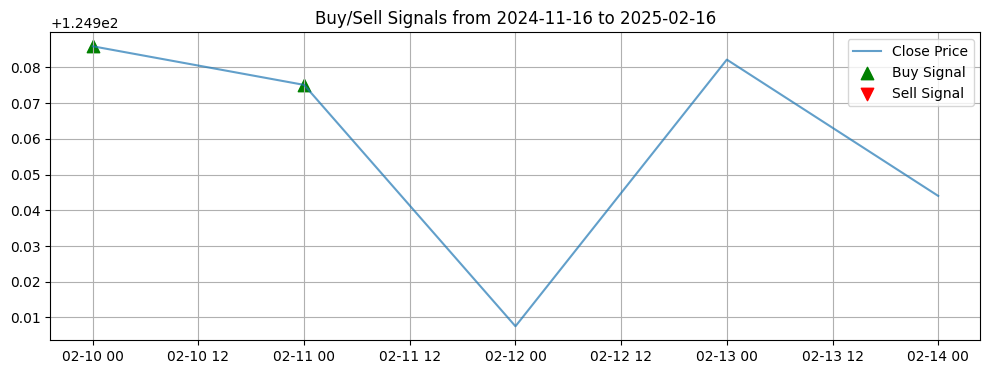

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ 1. 각 분기별 매수/매도 시점 차트 그리기
def plot_signals_by_quarter(df, signal, start, end):
    plt.figure(figsize=(12, 4))
    plt.plot(df['close'], label='Close Price', alpha=0.7)

    buy_signals = df[signal == -1]
    sell_signals = df[signal == 1]

    plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', s=80)
    plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', s=80)

    plt.title(f'Buy/Sell Signals from {start} to {end}')
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ 2. 유전자 알고리즘 피트니스 그래프
def plot_ga_fitness(ga_instance):
    plt.figure(figsize=(8, 4))
    plt.plot(ga_instance.best_solutions_fitness, label='Best Fitness per Generation', color='blue')
    plt.title('Genetic Algorithm Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()

# ✅ 최종 결과(각 분기별 성과)를 바탕으로 매매 신호 차트 그리기
print("\n--- 각 테스트 기간별 매매 신호 시각화 ---")
for i, row in result_df.iterrows():
    # 해당 분기(테스트 기간)의 데이터만 선택
    df_quarter = df.loc[row['start']:row['end']].copy()

    # !! 중요: 전진 분석 시 해당 분기를 위해 찾았던 최적의 파라미터를 사용 !!
    params_for_quarter = row['best_params']

    # 최적 파라미터로 지표와 신호를 다시 계산
    df_ind = compute_indicators(df_quarter, params_for_quarter)
    signal = generate_signal(df_ind)

    # 수정된 플롯 함수를 호출하여 차트 그리기
    plot_signals_by_quarter(df_ind, signal, row['start'], row['end'])


# 버전 2: 슬라이딩 윈도우 미적용 코드 (6개월치 백테스팅)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pygad
from backtesting import Backtest, Strategy
from datetime import timedelta
import matplotlib.pyplot as plt

# ✅ Smoothed price
def smooth_price(df, p=5, t=5):
    df = df.copy()
    df['close'] = df['close'].ewm(span=p).mean().ewm(span=t).mean()
    return df

# ✅ GDC 기반 전략 (매도 시 1% 수수료)
class GDCStrategy(Strategy):
    def init(self):
        self.signal = self.data.signal
        self.last_signal = None

    def next(self):
        # ==================== 마지막날에 남은 주식 모두 매도하는 로직 추가 ====================
        if self.I == len(self.data) - 1:
              if self.position:
                  self.position.close()
              return

        current_signal = self.signal[-1]
        price = self.data.Close[-1]

        # ==================== 매수, 매도 시그널 바뀜 수정(-1 매수, 1 매도) ====================
        if self.position:
            if current_signal == -1 and self.position.is_short:
                self.position.close()
                self.buy()

            elif current_signal == 1 and self.position.is_long:
                self.position.close(size=self.position.size, reduce_only=False)
                self.sell()
        else:
            if current_signal == -1:
                self.buy()
            elif current_signal == 1:
                self.sell()

# ✅ SMA, EMA, MACD, RSI, Stochastic, ROC만 사용
def compute_indicators(df, params):
    df = df.copy()
    df = smooth_price(df)

    # SMA
    df['SMA'] = df['close'].rolling(int(params[0])).mean() - df['close'].rolling(int(params[1])).mean()

    # EMA
    df['EMA'] = df['close'].ewm(span=int(params[2]), adjust=False).mean() - df['close'].ewm(span=int(params[3]), adjust=False).mean()

    # MACD
    macd_fast = df['close'].ewm(span=int(params[4]), adjust=False).mean()
    macd_slow = df['close'].ewm(span=int(params[5]), adjust=False).mean()
    df['MACD'] = macd_fast - macd_slow
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # signal line

    # RSI
    delta = df['close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(int(params[6])).mean()
    ma_down = down.rolling(int(params[6])).mean()
    rs = ma_up / (ma_down + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic: %K, %D
    low_min = df['low'].rolling(int(params[7])).min()
    high_max = df['high'].rolling(int(params[7])).max()
    df['Stoch_K'] = (df['close'] - low_min) / (high_max - low_min + 1e-10) * 100
    df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()

    # ROC
    df['ROC'] = df['close'].pct_change(periods=int(params[8])) * 100

    # 수정 1
    df = df.dropna().copy()
    return df
    # return df.dropna()


# ✅ 신호 생성 함수 - 지정된 단일 지표에 대한 매매 신호(-1, 0, 1) 생성하도록 변경
def generate_single_indicator_signal(df, indicator_name):
    signals = pd.Series(index=df.index, data=0) # 0으로 초기화

    if indicator_name == 'SMA':
        signals[df['SMA'] > 0] = -1 # 단기 > 장기 (매수)
        signals[df['SMA'] < 0] = 1  # 단기 < 장기 (매도)
    elif indicator_name == 'EMA':
        signals[df['EMA'] > 0] = -1
        signals[df['EMA'] < 0] = 1
    elif indicator_name == 'MACD':
        signals[df['MACD'] > df['MACD_Signal']] = -1 # MACD > Signal (매수)
        signals[df['MACD'] < df['MACD_Signal']] = 1  # MACD < Signal (매도)
    elif indicator_name == 'RSI':
        signals[df['RSI'] < 30] = -1 # 과매도 (매수)
        signals[df['RSI'] > 70] = 1  # 과매수 (매도)
    elif indicator_name == 'Stochastic':
        signals[df['Stoch_K'] > df['Stoch_D']] = -1 # %K > %D (매수)
        signals[df['Stoch_K'] < df['Stoch_D']] = 1  # %K < %D (매도)
    elif indicator_name == 'ROC':
        signals[df['ROC'] > 0] = -1 # 상승 추세 (매수)
        signals[df['ROC'] < 0] = 1  # 하락 추세 (매도)

    return signals.values

def fitness_func_single_indicator(ga_instance, solution, solution_idx):
    # 이 함수는 루프 안에서 동적으로 생성될 것이므로, 아래 메인 코드 부분을 참고해주세요.
    # 여기서는 개념 설명을 위해 비워둡니다.
    pass

def safe_commission(trade, order):
    try:
        return 0.01 * trade.value if hasattr(trade, 'is_short') and (trade.is_short or trade.side == 'sell') else 0
    except Exception:
        return 0

# def safe_commission(trade, order):
#     # 매도 거래이고, 포지션을 새로 여는 거래가 아닐 경우 (즉, 청산 목적이면)
#     if trade.side == 'sell' and not trade.is_entry:
#         return 0.01 * trade.value
#     return 0

# ✅ 커스텀 수수료 적용 (매도 시에만 1% 적용)
def backtest(df, signal):
    df_bt = df.copy()
    df_bt['signal'] = signal
    df_bt = df_bt[['open', 'high', 'low', 'close', 'volume', 'signal']].dropna()
    df_bt.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    df_bt.index.name = 'Date'
    bt = Backtest(
    df_bt,
    GDCStrategy,
    cash=100_000,
    commission=safe_commission,
    exclusive_orders=True
    )

    stats = bt.run()
    return stats['Return [%]'] / 100, stats['Max. Drawdown [%]'] / 100, stats['Sharpe Ratio']


# =====================================================================================================================================
# 추가
# ✅ 데이터 로드
df_all = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stock/tictocstock.csv", parse_dates=['Date'])
df_all.columns = df_all.columns.str.strip().str.lower()
df_all = df_all[['date', 'ticker', 'open', 'high', 'low', 'close', 'volume']]
df_all.sort_values(['ticker', 'date'], inplace=True)

# ✅ TJX 데이터 불러오기, 학습/테스트 데이터 생성
df = df_all[df_all['ticker'] == 'TJX'].set_index('date').copy().ffill()

split_date = df.index.max() - pd.DateOffset(months=6)
df_train = df[df.index < split_date].copy()
df_test = df[df.index >= split_date].copy()

print("📘 학습 데이터 기간:", df_train.index.min().date(), "~", df_train.index.max().date())
print("📙 백테스트 데이터 기간:", df_test.index.min().date(), "~", df_test.index.max().date())

# ✅ GA 피트니스 함수 (학습용 데이터로만 사용)
def fitness_func(ga, solution, idx):
    try:
        params = [max(2, int(round(p))) for p in solution]
        if not (params[0] < params[1] and params[2] < params[3] and params[4] < params[5]):
            return -np.inf
        df_ind = compute_indicators(df_train, params)
        signal = generate_signal(df_ind)
        profit, mdd, sharpe = backtest(df_ind, signal)
        return 0.8 * profit + 0.2 * (1 / mdd)
    except:
        return -np.inf

# ✅ 각 지표별 유전자 범위 설정
indicator_configs = {
    'SMA':        {'param_indices': [0, 1], 'gene_space': [{'low': 5, 'high': 50}, {'low': 10, 'high': 60}]},
    'EMA':        {'param_indices': [2, 3], 'gene_space': [{'low': 5, 'high': 50}, {'low': 10, 'high': 60}]},
    'MACD':       {'param_indices': [4, 5], 'gene_space': [{'low': 5, 'high': 25}, {'low': 26, 'high': 60}]},
    'RSI':        {'param_indices': [6],    'gene_space': [{'low': 5, 'high': 30}]},
    'Stochastic': {'param_indices': [7],    'gene_space': [{'low': 5, 'high': 40}]},
    'ROC':        {'param_indices': [8],    'gene_space': [{'low': 5, 'high': 30}]},
}



# ✅ GA 실행 후 최적 파라미터 출력 (기존과 동일)
ga = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_func,
    sol_per_pop=20,
    num_genes=9,
    gene_space=gene_space,
    gene_type=float,
    mutation_type="random",
    mutation_percent_genes=20
)
ga.run()
best_params = [int(round(g)) for g in ga.best_solution()[0]]
print("✅ 최적 파라미터:", best_params)

# ✅ 백테스트 (검증용 데이터에 대해 수행)
df_test_ind = compute_indicators(df_test, best_params)
signal_test = generate_signal(df_test_ind)
profit, mdd, sharpe = backtest(df_test_ind, signal_test)

# # ✅ 결과 출력
print("📊 백테스트 결과 (최근 6개월)")
print("수익률:", round(profit * 100, 2), "%")
print("최대 낙폭:", round(mdd * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe, 3))

# from collections import Counter

# # ✅ 시그널 분포 출력
# signal_counter = Counter(signal_test)
# # np.int64로 출력 형식 맞춤
# formatted_counts = {f"np.int64({k})": f"np.int64({v})" for k, v in signal_counter.items()}
# print(f"📊 [{df_test_ind.index.min().date()} ~ {df_test_ind.index.max().date()}] 시그널 분포:", formatted_counts)

# # ✅ 성과 요약 테이블 출력
# import pandas as pd
# result_df = pd.DataFrame([{
#     'start': df_test_ind.index.min().date(),
#     'end': df_test_ind.index.max().date(),
#     'profit': round(profit * 100, 2),
#     'mdd': round(mdd * 100, 2),
#     'sharpe': round(sharpe, 3)
# }])

# print(result_df.to_string(index=False))

# 위 코드 결과 시각화

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ 2. 유전자 알고리즘 피트니스 그래프
def plot_ga_fitness(ga_instance):
    plt.figure(figsize=(8, 4))
    plt.plot(ga_instance.best_solutions_fitness, label='Best Fitness per Generation', color='blue')
    plt.title('Genetic Algorithm Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()

# ✅ 3. 최적 파라미터 보기 좋게 출력
def explain_best_params(params):
    names = [
        "SMA Short Window",  # params[0]
        "SMA Long Window",   # params[1]
        "EMA Short Window",  # params[2]
        "EMA Long Window",   # params[3]
        "MACD Fast",         # params[4]
        "MACD Slow",         # params[5]
        "RSI Period",        # params[6]
        "Stochastic Period", # params[7]
        "ROC Period",        # params[8]
    ]
    print("✅ 최적 파라미터 해석")
    for name, val in zip(names, params):
        print(f" - {name:20}: {val}")

# ✅ 예시 실행
# 설명 출력
explain_best_params([6, 39, 14, 54, 15, 56, 7, 28, 21])

# 피트니스 시각화
plot_ga_fitness(ga)

# ✅ 시그널 시각화 (1): 종가 + 시그널
plt.figure(figsize=(14, 6))
plt.plot(df_test_ind.index, df_test_ind['close'], label='Close Price', color='gray')

buy_signals = df_test_ind[signal_test == 1]
sell_signals = df_test_ind[signal_test == -1]

plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', s=100)

plt.title("📈 시그널 기반 종가 시각화")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()